In [1]:
# Avner Khan, Kirana Raja, Abhishek Khare, Joshua Deng
import matplotlib.pyplot as plt
from amb_sdk.sdk import DarwinSdk
from time import sleep
import pandas as pd
import numpy as np
import sklearn.model_selection as ms
from sklearn.metrics import classification_report
import datetime

ds = DarwinSdk()
ds.set_url('https://amb-demo-api.sparkcognition.com/v1/')
ts = '{:%Y%m%d%H%M%S}'.format(datetime.datetime.now())


In [2]:

#Create a new user
status, msg = ds.auth_login_user('AVNERKHAN@UTEXAS.edu', 'xcGPvw7VMm')
if not status:
    print(msg)
print(status)

True


In [7]:
def elapsed_time(oc_date, oc_time, rep_date, rep_time):
    oc_date_split_arr = oc_date.split("/")
    oc_date_month = oc_date_split_arr[0]
    oc_date_day = oc_date_split_arr[1]
    oc_date_year = oc_date_split_arr[2]
    oc_hr = int(oc_time // 100)
    if (oc_hr > 23):
        oc_hr = 23
    elif (oc_hr < 0):
        oc_hr = 0
    oc_min = int(oc_time % 100)
    if (oc_min > 59):
        oc_min = 59
    elif (oc_min < 0):
        oc_min = 0
    oc_datetime = datetime.datetime(int(oc_date_year), int(oc_date_month), int(oc_date_day), oc_hr, oc_min)
    rep_date_split_arr = rep_date.split("/")
    rep_date_month = rep_date_split_arr[0]
    rep_date_day = rep_date_split_arr[1]
    rep_date_year = rep_date_split_arr[2]
    rep_hr = int(rep_time // 100)
    if (rep_hr > 23):
        rep_hr = 23
    elif (rep_hr < 0):
        rep_hr = 0
    rep_min = int(rep_time % 100)
    if (rep_min > 59):
        rep_min = 59
    elif (rep_min < 0):
        rep_min = 0
    rep_datetime = datetime.datetime(int(rep_date_year), int(rep_date_month), int(rep_date_day), rep_hr, rep_min)
    elapsed = rep_datetime - oc_datetime
    return elapsed.total_seconds() / 3600

dataset = pd.read_csv("Crime_Reports.csv")
# print(len(dataset))
dataset = dataset.drop(columns=['Location', 'Category Description', 'UCR Category', 'PRA', 'APD Sector', 'APD District', 'Council District', 'Zip Code', 'Address', 'Incident Number', 'Highest Offense Description', 'Occurred Date Time', 'Report Date Time', 'Clearance Date', 'X-coordinate', 'Y-coordinate', 'Latitude', 'Longitude'])
# print(dataset.head())
dataset = dataset.dropna()
elapsed = []
for index, row in dataset.iterrows():
    elapsed.append(elapsed_time(row['Occurred Date'], row['Occurred Time'], row['Report Date'], row['Report Time']))
elapsed_df = pd.DataFrame(data=elapsed)
dataset['Elapsed Time'] = elapsed_df
dataset = dataset.drop(columns=['Occurred Date', 'Occurred Time', 'Report Date', 'Report Time'])
print(len(dataset))
print(dataset.head())
dataset.to_csv('Cleaned_Crime_Reports_Full.csv')

1516122
   Highest Offense Code Family Violence                 Location Type  \
0                  2716               N        GAS / SERVICE STATIONS   
1                   600               N              RESIDENCE / HOME   
2                   300               N  STREETS / HWY / ROAD / ALLEY   
4                  1803               N  STREETS / HWY / ROAD / ALLEY   
6                   601               N         PARKING LOTS / GARAGE   

   Census Tract Clearance Status  Elapsed Time  
0         11.00                C      0.250000  
1         21.07                N    213.783333  
2         18.04                O      0.000000  
4          7.00                C     11.216667  
6         11.00                N     75.283333  


In [19]:
# gb = dataset.groupby(['Clearance Status'])
# print(gb.groups)
# dataset = dataset.drop(111791)
# gb = dataset.groupby(['Clearance Status'])
# print(gb.groups)
# dataset.to_csv('Cleaned_Crime_Reports_Full.csv')

In [27]:
status, message = ds.delete_dataset("Cleaned_Crime_Reports_Full.csv")
print(status, message)

True None


In [28]:
#Upload Dataset
status, uploaded_dataset = ds.upload_dataset("Cleaned_Crime_Reports_Full.csv")
if not status:
    print(uploaded_dataset)

target = "Clearance Status"
status, job_id = ds.clean_data("Cleaned_Crime_Reports_Full.csv", target = target)
if status:
    ds.wait_for_job(job_id['job_name'])
else:
    print(job_id)
    
#Creating Model
model = target + "_model1" + ts
status, message = ds.delete_model(model)
status, job_id = ds.create_model(dataset_names = "Cleaned_Crime_Reports_Full.csv", \
                                 model_name =  model, \
                                 max_train_time = '00:10')
if status:
    ds.wait_for_job(job_id['job_name'])
else:
    print(job_id)
    

{'status': 'Requested', 'starttime': '2019-04-17T20:41:03.166879', 'endtime': None, 'percent_complete': 0, 'job_type': 'CleanDataTiny', 'loss': None, 'generations': None, 'dataset_names': ['Cleaned_Crime_Reports_Full.csv'], 'artifact_names': ['690e081386ca4ed5bdcc78bce2cba1fe'], 'model_name': None, 'job_error': None}
{'status': 'Requested', 'starttime': '2019-04-17T20:41:03.166879', 'endtime': None, 'percent_complete': 0, 'job_type': 'CleanDataTiny', 'loss': None, 'generations': None, 'dataset_names': ['Cleaned_Crime_Reports_Full.csv'], 'artifact_names': ['690e081386ca4ed5bdcc78bce2cba1fe'], 'model_name': None, 'job_error': None}
{'status': 'Requested', 'starttime': '2019-04-17T20:41:03.166879', 'endtime': None, 'percent_complete': 0, 'job_type': 'CleanDataTiny', 'loss': None, 'generations': None, 'dataset_names': ['Cleaned_Crime_Reports_Full.csv'], 'artifact_names': ['690e081386ca4ed5bdcc78bce2cba1fe'], 'model_name': None, 'job_error': None}
{'status': 'Requested', 'starttime': '2019-

{'status': 'Running', 'starttime': '2019-04-17T20:45:20.458146', 'endtime': None, 'percent_complete': 0, 'job_type': 'TrainModel', 'loss': None, 'generations': 0, 'dataset_names': ['Cleaned_Crime_Reports_Full.csv'], 'artifact_names': None, 'model_name': 'Clearance Status_model120190417200339', 'job_error': ''}
{'status': 'Running', 'starttime': '2019-04-17T20:45:20.458146', 'endtime': None, 'percent_complete': 0, 'job_type': 'TrainModel', 'loss': None, 'generations': 0, 'dataset_names': ['Cleaned_Crime_Reports_Full.csv'], 'artifact_names': None, 'model_name': 'Clearance Status_model120190417200339', 'job_error': ''}
{'status': 'Running', 'starttime': '2019-04-17T20:45:20.458146', 'endtime': None, 'percent_complete': 0, 'job_type': 'TrainModel', 'loss': None, 'generations': 0, 'dataset_names': ['Cleaned_Crime_Reports_Full.csv'], 'artifact_names': None, 'model_name': 'Clearance Status_model120190417200339', 'job_error': ''}
{'status': 'Running', 'starttime': '2019-04-17T20:45:20.458146',

{'status': 'Running', 'starttime': '2019-04-17T20:45:20.458146', 'endtime': None, 'percent_complete': 20, 'job_type': 'TrainModel', 'loss': 0.8249086141586304, 'generations': 0, 'dataset_names': ['Cleaned_Crime_Reports_Full.csv'], 'artifact_names': None, 'model_name': 'Clearance Status_model120190417200339', 'job_error': ''}
{'status': 'Running', 'starttime': '2019-04-17T20:45:20.458146', 'endtime': None, 'percent_complete': 20, 'job_type': 'TrainModel', 'loss': 0.8249086141586304, 'generations': 0, 'dataset_names': ['Cleaned_Crime_Reports_Full.csv'], 'artifact_names': None, 'model_name': 'Clearance Status_model120190417200339', 'job_error': ''}
{'status': 'Running', 'starttime': '2019-04-17T20:45:20.458146', 'endtime': None, 'percent_complete': 20, 'job_type': 'TrainModel', 'loss': 0.8249086141586304, 'generations': 0, 'dataset_names': ['Cleaned_Crime_Reports_Full.csv'], 'artifact_names': None, 'model_name': 'Clearance Status_model120190417200339', 'job_error': ''}
{'status': 'Running

In [31]:
#Analyzing Models
status, artifact = ds.analyze_model(model)
sleep(1)
if status:
    ds.wait_for_job(artifact['job_name'])
else:
    print(artifact)
status, feature_importance = ds.download_artifact(artifact['artifact_name'])

{'status': 'Running', 'starttime': '2019-04-17T21:01:40.948478', 'endtime': None, 'percent_complete': 0, 'job_type': 'AnalyzeModel', 'loss': 0.8249086141586304, 'generations': 0, 'dataset_names': None, 'artifact_names': ['e4764ed2b3a34399b1af2bb2a7a9ec87'], 'model_name': 'Clearance Status_model120190417200339', 'job_error': ''}
{'status': 'Failed', 'starttime': '2019-04-17T21:01:40.948478', 'endtime': '2019-04-17T21:01:56.58548', 'percent_complete': 100, 'job_type': 'AnalyzeModel', 'loss': 0.8249086141586304, 'generations': 0, 'dataset_names': None, 'artifact_names': ['e4764ed2b3a34399b1af2bb2a7a9ec87'], 'model_name': 'Clearance Status_model120190417200339', 'job_error': 'FailedDownload: Failed to download entity of type Object from location models/d75c7a7c-4f31-11e9-a91d-5383db4f861f_Clearance Status_model120190417200339/skl_model/data_profiler_main_minified'}


In [32]:
print(feature_importance)

404: NOT FOUND - {"message": "Failed to find artifact e4764ed2b3a34399b1af2bb2a7a9ec87"}



{'status': 'Running', 'starttime': '2019-04-17T19:32:43.785781', 'endtime': None, 'percent_complete': 0, 'job_type': 'RunModel', 'loss': 0.45539912581443787, 'generations': 4, 'dataset_names': ['Cleaned_Crime_Reports.csv'], 'artifact_names': ['8022646e2c364bb189a3600e0d904606'], 'model_name': 'Clearance Status_model020190417192044', 'job_error': ''}
{'status': 'Complete', 'starttime': '2019-04-17T19:32:43.785781', 'endtime': '2019-04-17T19:32:45.148437', 'percent_complete': 100, 'job_type': 'RunModel', 'loss': 0.45539912581443787, 'generations': 4, 'dataset_names': ['Cleaned_Crime_Reports.csv'], 'artifact_names': ['8022646e2c364bb189a3600e0d904606'], 'model_name': 'Clearance Status_model020190417192044', 'job_error': ''}
  Clearance Status    prob_C    prob_N    prob_O
0                C  0.886038  0.100522  0.013439
1                N  0.097599  0.869356  0.033046
2                N  0.043262  0.945537  0.011201
3                C  0.767995  0.192197  0.039808
4                N  0.06

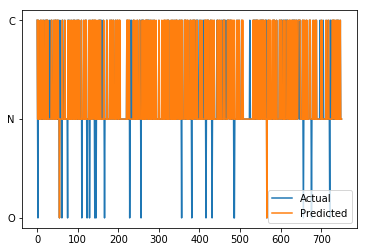

In [27]:
status, artifact = ds.run_model("Cleaned_Crime_Reports_Full.csv", model)
sleep(1)
ds.wait_for_job(artifact['job_name'])

status, prediction = ds.download_artifact(artifact['artifact_name'])
print(prediction.head())

unq = prediction[target].unique()[::-1]
p = np.zeros((len(prediction),))
a = np.zeros((len(prediction),))
for i,q in enumerate(unq):
    p += i*(prediction[target] == q).values
    a += i*(dataset[target] == q).values
#Plot predictions vs actual
plt.plot(a)
plt.plot(p)
plt.legend(['Actual','Predicted'])
plt.yticks([i for i in range(len(unq))],[q for q in unq]);
print(classification_report(dataset[target], prediction[target]))

In [28]:
status, model_type = ds.lookup_model_name(model)
print(model_type['description']['best_genome'])

[{'layer 1': {'type': 'LinearGene', 'parameters': {'activation': 'identity', 'numunits': 59}}}, {'layer 2': {'type': 'LinearGene', 'parameters': {'activation': 'relu', 'numunits': 32}}}, {'layer 3': {'type': 'LinearGene', 'parameters': {'activation': 'relu', 'numunits': 52}}}, {'layer 4': {'type': 'LinearGene', 'parameters': {'activation': 'relu', 'numunits': 3}}}]
